In [1]:
!pip install gdown

In [2]:
import gdown

# File 1: Download the first dataset
file1_id = "1S0ozp5PYL1lGVeboCl3dS83vErEvjRmm"
file1_output = "emission.csv"
gdown.download(f"https://drive.google.com/uc?id={file1_id}", file1_output, quiet=False)

# File 2: Download the second dataset
file2_id = "1z-M19AmIQShz4WQmwbI7-qpRVyiAUTQ5"
file2_output = "year.csv"
gdown.download(f"https://drive.google.com/uc?id={file2_id}", file2_output, quiet=False)

# File 3: Download the third dataset
file3_id = "1LBUiSMnuIyPzXa7SZj8loXUWax3Fxnmk"
file3_output = "category.csv"
gdown.download(f"https://drive.google.com/uc?id={file3_id}", file3_output, quiet=False)

# File 3: Download the third dataset
file4_id = "1xyOx81w0E58cVKWaFtpjSJRk2djEA1J8"
file4_output = "type.csv"
gdown.download(f"https://drive.google.com/uc?id={file4_id}", file4_output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1S0ozp5PYL1lGVeboCl3dS83vErEvjRmm
To: /content/emission.csv
100%|██████████| 19.6k/19.6k [00:00<00:00, 3.88MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z-M19AmIQShz4WQmwbI7-qpRVyiAUTQ5
To: /content/year.csv
100%|██████████| 262/262 [00:00<00:00, 796kB/s]
Downloading...
From: https://drive.google.com/uc?id=1LBUiSMnuIyPzXa7SZj8loXUWax3Fxnmk
To: /content/category.csv
100%|██████████| 89.0/89.0 [00:00<00:00, 111kB/s]
Downloading...
From: https://drive.google.com/uc?id=1xyOx81w0E58cVKWaFtpjSJRk2djEA1J8
To: /content/type.csv
100%|██████████| 72.0/72.0 [00:00<00:00, 155kB/s]


'type.csv'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Load the datasets
emissions_df = pd.read_csv('emission.csv')
category_df = pd.read_csv('category.csv')
year_df = pd.read_csv('year.csv')
type_df = pd.read_csv('type.csv')

# Step 1: Merge the emissions_df with category_df based on 'PK_category' to replace category PK with category names
emissions_df = emissions_df.merge(category_df, on='PK_category', how='left')

# Step 2: Merge the emissions_df with year_df based on 'PK_year' to replace year PK with fiscal year
emissions_df = emissions_df.merge(year_df[['PK_year', 'FiscalYear']], on='PK_year', how='left')

# Step 3: Merge with type_df to include type names
emissions_df = emissions_df.merge(type_df, on='PK_EmissionType', how='left')

# Step 4: Drop the original PK columns if you no longer need them
emissions_df.drop(columns=['PK_category', 'PK_year', 'PK_EmissionType'], inplace=True)

# Step 5: One-hot encode categorical variables
emissions_df_encoded = pd.get_dummies(emissions_df, columns=['categoryName', 'TypeName'], drop_first=True)

# Step 6: Filter out rows where Emissions exceed 4270
emissions_df_encoded = emissions_df_encoded[emissions_df_encoded['Emissions'] <= 4270]

# Step 7: Define features (X) and target variable (y)
X = emissions_df_encoded.drop('Emissions', axis=1)  # Features
y = emissions_df_encoded['Emissions']  # Target variable

# Step 8: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Create an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Step 10: Train the model
xgb_model.fit(X_train, y_train)

# Step 11: Make predictions
y_pred = xgb_model.predict(X_test)

# Step 12: Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Step 13: Output the metrics
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

# Step 14: Function for user input predictions
def predict_emissions(category_name, fiscal_year, type_name):
    input_data = pd.DataFrame({
        'categoryName': [category_name],
        'FiscalYear': [fiscal_year],
        'TypeName': [type_name],
    })

    # One-hot encode the input data using the same encoding as in training
    input_encoded = pd.get_dummies(input_data, columns=['categoryName', 'TypeName'], drop_first=True)

    # Align the input data with the training features
    input_encoded = input_encoded.reindex(columns=X.columns, fill_value=0)

    # Make prediction
    prediction = xgb_model.predict(input_encoded)

    return prediction[0]

Mean Absolute Error: 7027.915892017723
Root Mean Squared Error: 16058.195563959156


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


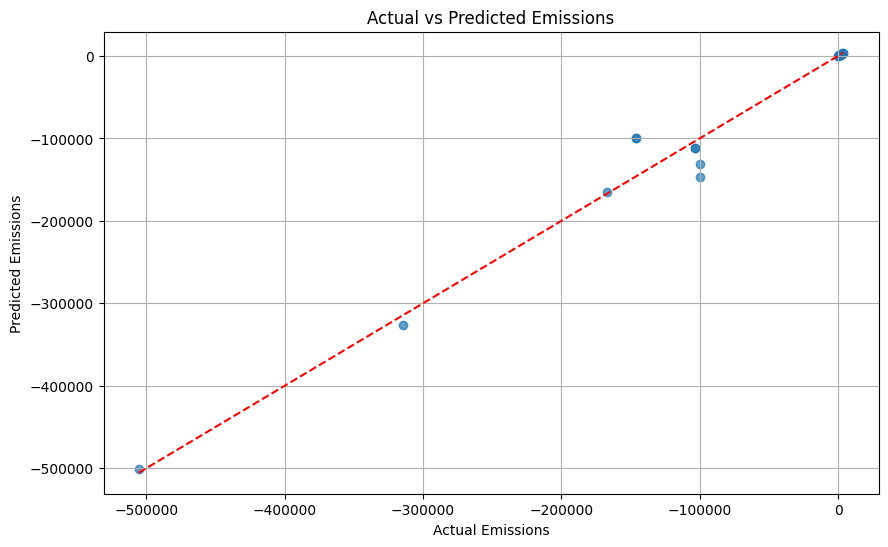

<Figure size 1000x600 with 0 Axes>

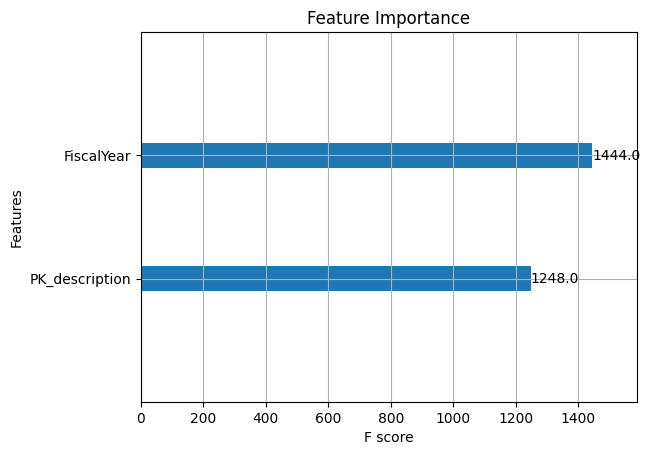

Predicted Emissions for Corporate emissions in 2000 with type Gross emissions: 3922.650634765625


In [6]:
import matplotlib.pyplot as plt
# Example usage
category_input = 'Corporate emissions'  # User inputs
fiscal_year_input = 2000  # User inputs
type_input = 'Gross emissions'  # User inputs

# Step 15: Plotting function for predictions vs actual emissions
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title('Actual vs Predicted Emissions')
    plt.xlabel('Actual Emissions')
    plt.ylabel('Predicted Emissions')
    plt.grid()
    plt.show()

plot_predictions(y_test, y_pred)

# Step 17: Revised plotting feature importance function
def plot_feature_importance(model):
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(model, max_num_features=10, importance_type='weight', title='Feature Importance')
    plt.show()

# Step 18: Call the feature importance plotting function
plot_feature_importance(xgb_model)

predicted_emission = predict_emissions(category_input, fiscal_year_input, type_input)
print(f"Predicted Emissions for {category_input} in {fiscal_year_input} with type {type_input}: {predicted_emission}")